# 王者荣耀英雄定位的区分度分析

# 目录
1. [摘要](#abstract)
2. [前言](#intro)
3. [英雄综合属性](#p1)
    * [综合属性特征工程](#s1)
    * [综合属性聚类分析](#s2)
4. [初始属性板块](#p2)
    * [初始属性特征工程](#s3)
    * [初始属性聚类分析](#s4)
5. [铭文板块](#p3)
    * [铭文板块特征工程](#s5)
    * [铭文板块聚类分析](#s6)
6. [装备板块](#p4)
    * [装备板块聚类分析](#s7)
7. [最后讨论](#p5)  

# 摘要<a name="abstract"></a>

自2015年11月26日王者荣耀发行以来，王者峡谷里面一共出现了101位英雄，各自属于五个不同的位置：刺客、射手、战士、法师、辅助。这些英雄在这五个位置上各司其职，互相配合，完成了一场又一场精彩的团战。本项目将通过对英雄数据的聚类质量好坏来分别评估王者荣耀的设计师在如下三个板块中是否对英雄的定位有比较好的区分：英雄的初始属性板块、铭文板块和装备板块。最后的结论是：在初始属性板块中，所有定位的区分度都很低，各英雄的初始属性都很接近；在铭文板块中，法师和辅助的区分度很高；在装备板块中，法师和射手的区分度很高。

关键词：爬虫、MCA降维、K-menas聚类分析、t-SNE可视化、轮廓系数。


# 前言<a name="intro"></a>

1984年，统计学家Anton K. Formann建议K-means聚类算法的数据量至少需要2<sup>m</sup>个,其中m为特征的个数。但是在我们爬取到的4份英雄数据中，特征维数在9~71之间，而英雄总数只有101个，远远达不到上述要求。幸运的是，本项目的目标不是对这101位英雄做无监督聚类，相反，我们是有各个英雄的真实定位的。因此，我们可以反过来，给每个英雄标上其真实定位后，计算这些英雄在特征空间的分布的轮廓系数：轮廓系数越接近1，在该特征空间，不同定位的英雄的区分度越高。另一方面，若要看某一定位（例如法师）在该特征空间是否能很容易区分开来，我们可以直接在该特征空间对英雄进行聚类分析，聚类结果中该定位（例如法师）的f1-score越高，则在该特征空间越容易形成聚类，因此该定位的区分度就越大。综上，在本项目中我们有两个重要的指标：
* 整体区分度：英雄标上真实定位后在特征空间中的轮廓系数，取值在-1到1之间，值越大整体区分度就越高。
* (刺客/射手/战士/法师/辅助)区分度：在特征空间中对英雄做K-means聚类，将聚类结果作为预测结果，计算(刺客/射手/战士/法师/辅助)的f1-score，取值在0到1之间，值越大该定位的区分度就越高。

通过这两个指标，我们就可以分析出在英雄的初始属性板块、铭文板块和装备板块中，设计师是否对英雄的定位有很好的区分。我们通过爬虫（英雄数据爬虫.ipynb），获取并整理了18183游戏网的王者荣耀板块中的4份数据：
1. hero0.csv：英雄的初始属性。
2. minwen.csv：英雄搭配推荐铭文时获得的属性增益。
3. zhuangbei.csv：英雄的推荐出装，以one-hot码（0-1数据）表示。
4. hero_final.csv: 上面三个表的汇总表。

前面三份数据分别对应初始属性板块、铭文板块和装备板块，最后一份数据综合了考虑所有属性。接下来，我们将分别对这四份数据进行聚类分析并计算相应的区分度：

# 英雄综合属性<a name="p1"></a>

In [3]:
import pandas as pd
import seaborn as sns
import prince
import itertools
import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics
jtplot.reset()

In [2]:
%matplotlib inline

我们先对综合表进行分析，以便对数据的所有属性有一个整体的认识：

In [4]:
hero_final = pd.read_csv('hero_final.csv',index_col=False)
a = list(hero_final.columns[2:19])
b = list(hero_final.columns[19:])
display(hero_final.head())
print('王者荣耀总共含有{}个英雄：\n{}'.format(len(hero_final),', '.join((hero_final['英雄']))))
print('\n这{}个英雄有5个定位：{}'.format(len(hero_final),list((hero_final['定位'].unique()))))
print('\n英雄一共含有17个数值属性：\n{}'.format(', '.join(a)))
print('\n英雄所有推荐出装中一共包含了{}件装备：\n(1表示该英雄推荐出装中含有次此装备，0表示不含) \n{}'\
      .format(hero_final.columns.size-19,', '.join(b)))

,英雄,定位,最大生命,最大法力,物理攻击,法术攻击,物理防御,物理减伤率,移速,物理护甲穿透,...,贤者的庇护,贪婪之噬,辉月,近卫荣耀,追击刀锋,逐日之弓,闪电匕首,霸者重装,风灵纹章,魔女斗篷
0,曜,刺客,3225.0,3.0,194.0,0.0,94.0,0.14,407.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1,蒙犽,射手,3235.0,100.0,196.0,0.0,90.0,0.13,396.0,100.0,...,0,0,0,0,0,0,0,0,0,0
2,裴擒虎,刺客,3178.0,200.0,196.0,0.0,86.0,0.14,407.0,100.0,...,0,1,0,0,0,0,0,0,0,0
3,孙策,战士,3320.0,420.0,180.0,0.0,97.0,0.14,418.0,100.0,...,0,0,0,0,0,0,0,0,0,0
4,芈月,法师,3105.0,100.0,152.0,66.0,88.0,0.13,370.0,0.0,...,0,0,0,0,0,0,0,0,0,0


王者荣耀总共含有101个英雄：
曜, 蒙犽, 裴擒虎, 孙策, 芈月, 元歌, 张飞, 小乔, 太乙真人, 花木兰, 女娲, 牛魔, 上官婉儿, 诸葛亮, 宫本武藏, 嬴政, 哪吒, 蔡文姬, 干将莫邪, 盘古, 周瑜, 艾琳, 后羿, 李元芳, 雅典娜, 明世隐, 瑶, 鬼谷子, 杨玉环, 刘备, 露娜, 东皇太一, 高渐离, 亚瑟, 西施, 橘右京, 虞姬, 米莱狄, 王昭君, 甄姬, 狂铁, 云中君, 鲁班大师, 杨戬, 孙悟空, 貂蝉, 嫦娥, 马超, 典韦, 扁鹊, 大乔, 姜子牙, 蒙恬, 狄仁杰, 李白, 关羽, 不知火舞, 庄周, 安琪拉, 妲己, 张良, 梦奇, 达摩, 沈梦溪, 兰陵王, 弈星, 韩信, 孙尚香, 赵云, 公孙离, 娜可露露, 镜, 武则天, 曹操, 鲁班七号, 马可波罗, 钟无艳, 李信, 猪八戒, 铠, 孙膑, 阿轲, 老夫子, 刘禅, 百里玄策, 司马懿, 白起, 刘邦, 钟馗, 吕布, 夏侯惇, 廉颇, 成吉思汗, 伽罗, 程咬金, 黄忠, 百里守约, 墨子, 苏烈, 项羽, 盾山

这101个英雄有5个定位：['刺客', '射手', '战士', '法师', '辅助']

英雄一共含有17个数值属性：
最大生命, 最大法力, 物理攻击, 法术攻击, 物理防御, 物理减伤率, 移速, 物理护甲穿透, 法术护甲穿透, 攻速加成, 暴击几率, 暴击效果, 物理吸血, 法术吸血, 冷却缩减, 生命回复, 法力回复

英雄所有推荐出装中一共包含了54件装备：
(1表示该英雄推荐出装中含有次此装备，0表示不含) 
不死鸟之眼, 不祥征兆, 冰痕之握, 冰霜法杖, 冷静之靴, 博学者之怒, 反伤刺甲, 名刀·司命, 噬神之书, 回响之杖, 圣杯, 圣者法典, 奔狼纹章, 守护者之铠, 宗师之力, 巨人之握, 巫术法杖, 影刃, 影忍之足, 急速战靴, 抵抗之靴, 救赎之翼, 无尽战刃, 时之预言, 暗影战斧, 暴烈之甲, 末世, 极寒风暴, 极影, 泣血之刃, 炽热支配者, 疾步之靴, 痛苦面具, 破军, 破晓, 破魔刀, 碎星锤, 神隐斗篷, 秘法之靴, 红莲斗篷, 纯净苍穹, 虚无法杖, 血魔之怒, 贤者之书, 贤者的庇护, 贪婪之噬, 辉月, 近卫荣耀, 追击刀锋, 逐日之弓, 闪电匕首, 霸者重装, 风灵纹章, 魔女斗篷


## 综合属性特征工程<a name="s1"></a>

我们总共有71个特征，其中17个为数值型特征，54个为类别特征（0-1型）。
* 对于数值型，我们通过热力图去掉相关性很大的特征。
* 对于类别特征（0-1型），由于一个英雄只能出6件装备，而总共有54件装备，这就导致数据太稀疏，我们需要对其降维。对类别特征最常用的降维方法为[MCA(Multiple correspondence analysis)](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/114-mca-multiple-correspondence-analysis-in-r-essentials/)，该方法是[CA(correspondence analysis)](http://euclid.psych.yorku.ca/www/psy6136/ClassOnly/VCDR/chapter06.pdf)的一个推广，用来处理类别数据。这两种方法本质上都是对列联表进行操作，试图用低维的数据点来代替高维数据，使得低维数据的贡献的‘惯量’（正比于列联表的卡方值）占高维数据‘惯量’的大部分。由于列联表的卡方值（‘惯量’）衡量了不同特征之间的关联程度，因此，只要低维数据能继承高维数据的大部分‘惯量’，就能保留了大部分高维数据各个特征之间的关联，从而达到了降维的效果，这和PCA降维的思想是类似的。

**数值型——特征工程**

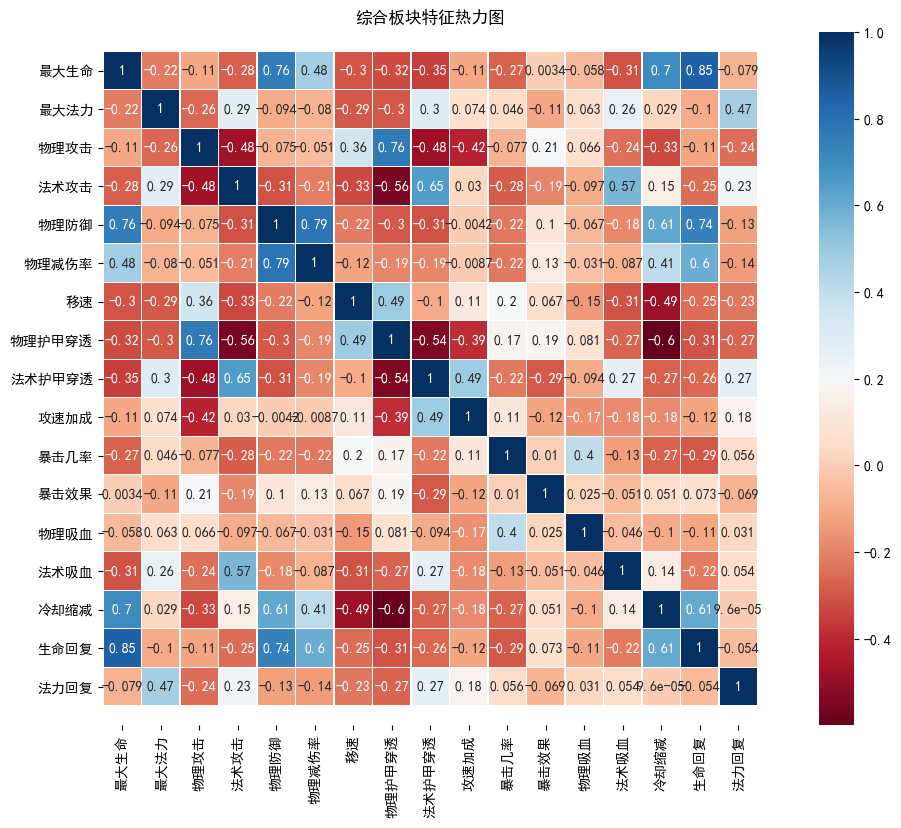

In [5]:
def feature(df,s,h,v):
    matplotlib.rcParams['font.sans-serif']=['SimHei'] 
    matplotlib.rcParams['axes.unicode_minus']=False   
    plt.figure(figsize=(h,v))
    ax = sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True,
                cmap=sns.color_palette('RdBu', n_colors=256),linecolor='white', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(s)
    plt.show()

feature(hero_final.iloc[:,2:19],'综合板块特征热力图',16,9)

从热力图可以看出，特征之间最大的Pearson相关系数为0.85，为了保险起见我们保留所有特征。

 **类别数据——特征工程**

接下来，我们采用[Prince开源包](https://github.com/MaxHalford/prince)来对54个类别特征进行MCA降维：

In [6]:
ca = prince.CA(n_components=20,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
ca = ca.fit(hero_final.iloc[:,19:])
# 由于我们已经将类别特征转化为0-1型数据，我们可以直接套用CA的计算方法。

print('低维数据(20维)的总惯量占高维数据(54维)总惯量的比例：{:.2f}%'.format(100*sum(ca.explained_inertia_)))
zhuangbei = ca.row_coordinates(hero_final.iloc[:,19:])
zhuangbei.head()

低维数据(20维)的总惯量占高维数据(54维)总惯量的比例：76.09%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.564379,0.645868,-0.719458,-0.041686,-0.597385,0.820842,-0.176957,0.408670,0.034245,1.322632,0.055724,0.413111,0.056311,-0.252991,0.218582,-0.367896,0.839732,0.722208,0.675866,-0.391581
1,-0.343670,-0.660499,0.793476,-0.337546,1.001861,2.297281,1.476187,-1.445487,-0.031358,-0.563567,-0.779756,-0.176549,1.412267,-0.730402,-0.097957,-0.775103,-0.532999,-1.137647,0.534960,0.032840
2,-0.800926,-0.313944,-0.726848,0.055847,0.091023,-0.058792,0.107468,-0.434481,-0.113266,-0.050242,0.242519,0.655535,-0.537895,-0.236607,-0.003118,-0.172291,0.287002,-0.029644,-0.277786,0.127696
3,-0.571499,0.023817,-1.526764,-0.299545,0.619490,1.443612,-1.236727,2.262457,2.447686,-1.077041,-0.473469,0.772234,0.419882,-0.087029,0.046705,0.304294,-1.211522,-0.383797,-0.886680,0.356117
4,1.281029,-0.267708,-0.140767,0.806202,-0.499742,-0.068563,-0.638116,0.107477,-1.023257,-0.377710,-1.305626,-0.297358,-0.486332,-0.691929,0.257211,0.567126,-0.470168,-0.410498,-0.351766,-0.337133


我们可以看到，54维降到25维可以保留原来75%以上的“惯量”，是一个较好的近似。最后，我们将所有数据进行归一化：

 **数据归一化**

In [7]:
def standardize(df):
    scaler = StandardScaler()
    scaler.fit(df); scaled_fea = scaler.transform(df)
    df1 = pd.DataFrame(data=scaled_fea,columns=df.columns)
    return df1
#定义归一化函数

a = standardize(hero_final.iloc[:,2:19]) #数值部分的归一化
b = zhuangbei
hero_final_n = pd.concat([a,b], axis=1, sort=False)
hero_final_n.head()

,最大生命,最大法力,物理攻击,法术攻击,物理防御,物理减伤率,移速,物理护甲穿透,法术护甲穿透,攻速加成,...,10,11,12,13,14,15,16,17,18,19
0,-0.401585,-1.761048,0.626713,-0.578557,-0.342464,0.077631,0.372497,1.300590,-0.561546,-1.228543,...,0.055724,0.413111,0.056311,-0.252991,0.218582,-0.367896,0.839732,0.722208,0.675866,-0.391581
1,-0.383134,-1.282715,0.729553,-0.578557,-0.555976,-0.575765,-0.007525,1.300590,-0.561546,-1.228543,...,-0.779756,-0.176549,1.412267,-0.730402,-0.097957,-0.775103,-0.532999,-1.137647,0.534960,0.032840
2,-0.488307,-0.789588,0.729553,-0.578557,-0.769487,0.077631,0.372497,1.300590,-0.561546,-1.228543,...,0.242519,0.655535,-0.537895,-0.236607,-0.003118,-0.172291,0.287002,-0.029644,-0.277786,0.127696
3,-0.226296,0.295290,-0.093167,-0.578557,-0.182330,0.077631,0.752519,1.300590,-0.561546,-0.079628,...,-0.473469,0.772234,0.419882,-0.087029,0.046705,0.304294,-1.211522,-0.383797,-0.886680,0.356117
4,-0.623003,-1.282715,-1.532928,2.107139,-0.662732,-0.575765,-0.905759,-0.967359,0.132937,-1.228543,...,-1.305626,-0.297358,-0.486332,-0.691929,0.257211,0.567126,-0.470168,-0.410498,-0.351766,-0.337133


至此，我们完成了所有的特征工程与特征归一化，最后剩下41个特征，101个英雄（样本）。

## 综合属性聚类分析<a name="s2"></a>

这一部分，我们进行K-means聚类，然后通过t-SNE对聚类结果进行可视化，并且分别计算K-means聚类标定结果和真实标定所对应的轮廓系数，同时给出K-means聚类的混淆矩阵：

In [8]:
ori_hero = pd.read_csv('hero_info.csv',index_col=False)
def kmeans(df):
    kmeans=KMeans(n_clusters=5,init='k-means++', 
                max_iter=100, n_init=1, verbose=0, random_state=7299)
    kmeans.fit(df)
    cluster_labels = kmeans.labels_
    sc = metrics.silhouette_score(df,cluster_labels)
    sc0 = metrics.silhouette_score(df,ori_hero['位置'])
    return kmeans, sc, sc0
# 定义K-means函数,并计算聚类结果的轮廓系数之和

def tsne(df,kmeans00,perp):
    df_embedded = TSNE(n_components=2,random_state=42,perplexity=perp).fit_transform(df)
    df_embedded = pd.DataFrame(df_embedded)
    df_embedded.columns = ['x','y']
    df_embedded['kmeans结果'] = kmeans00.labels_
    df_embedded['英雄真实定位'] = ori_hero['位置']
    return df_embedded
#定义tsne函数，用来获得t-SNE方法计算出的高维数据的二维坐标

def accuracy(data):
    permu = list(itertools.permutations([0, 1, 2, 3, 4])); maps = []
    for i in permu:
        keys = ['刺客','射手','战士','法师','辅助']
        maps.append(dict(zip(keys, i)))
    right_n = [];
    for j in maps:
        yzzsdw = data['英雄真实定位'].map(j)
        right = sum(data['kmeans结果'] == yzzsdw)
        right_n.append(right)
    jm = right_n.index(max(right_n))
    map_m = maps[jm]; right_m = right_n[jm]
    map_rev = dict(zip(map_m.values(),map_m.keys()))
    y_true = data['英雄真实定位']
    y_pred = data['kmeans结果'].map(map_rev)
    report = metrics.classification_report(y_true,y_pred,output_dict=True,digits=2) #计算混淆矩阵
    result = pd.DataFrame(report).transpose()
    return map_m, right_m/101, result
# 定义准确率函数，因为K-means聚类返回的标定结果为数字，而真实标定结果为中文
# 通过遍历所有排列，找出二者匹配最多的情况，最后由计算混淆矩阵

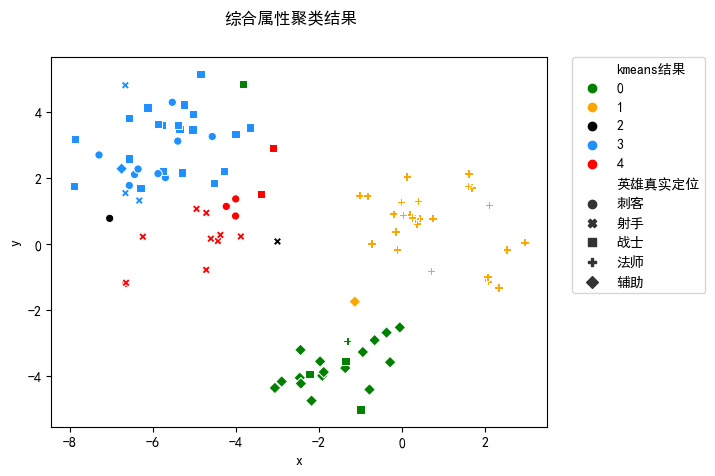

考虑综合属性时:

真实结果的轮廓系数为：0.10809824222616322（整体区分度）
聚类结果的轮廓系数为：0.22487155711719192
聚类结果的最大准确率为：74.26%
聚类结果最大准确率对应关系：{'刺客': 2, '射手': 4, '战士': 3, '法师': 1, '辅助': 0}


,precision,recall,f1-score,support
刺客,0.50,0.07,0.12,14.00
射手,0.62,0.71,0.67,14.00
战士,0.61,0.77,0.68,26.00
法师,0.97,0.97,0.97,29.00
辅助,0.76,0.89,0.82,18.00
accuracy,0.74,0.74,0.74,0.74
macro avg,0.69,0.68,0.65,101.00
weighted avg,0.72,0.74,0.71,101.00


In [9]:
kmeans0 = kmeans(hero_final_n)[0]; #K-means聚类学习过程
SC_k0 = kmeans(hero_final_n)[1]; SC_r0 = kmeans(hero_final_n)[2]; #求轮廓系数
data_2d0 = tsne(hero_final_n,kmeans0,35) #t-SNE可视化，求出低维坐标
mapp0 = accuracy(data_2d0)[0]; accur0 =accuracy(data_2d0)[1]; result0 = accuracy(data_2d0)[2];

matplotlib.rcParams['font.sans-serif']=['SimHei'] 
matplotlib.rcParams['axes.unicode_minus']=False 
ax = sns.scatterplot(x='x', y='y', hue="kmeans结果",data=data_2d0,style='英雄真实定位',
                     palette=['green','orange','black','dodgerblue','red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('综合属性聚类结果')
plt.show()

print('考虑综合属性时:\n')
print('真实结果的轮廓系数为：{}（整体区分度）'.format(SC_r0))
print('聚类结果的轮廓系数为：{}'.format(SC_k0))
print('聚类结果的最大准确率为：{:.2f}%'.format(100*accur0))
print('聚类结果最大准确率对应关系：{}'.format(mapp0))
pd.options.display.float_format = '{:,.2f}'.format
display(result0)

可以看到，考虑英雄的综合属性时，整体区分度为0.105。通过f1-score可以看出，英雄的综合属性对法师和辅助的区分度很高，其中法师的f1-score达到了0.97，而刺客、战士和射手混在了一起。

接下来，我们分别对英雄的初始属性板块、铭文板块和装备板块做聚类分析，看看在这三个子板块中英雄设计师是否对他们的定位有比较好的区分度。

# 初始属性板块<a name="p2"></a>

In [10]:
hero0 = pd.read_csv('hero0.csv',index_col=False)
hero0.head()

,最大生命,最大法力,物理攻击,物理防御,物理减伤率,移速,暴击效果,生命回复,法力回复
0,3225,3,149,94,0.14,370,2.00,49,0
1,3235,100,151,90,0.13,360,2.00,40,0
2,3178,200,151,86,0.14,370,2.00,45,50
3,3320,420,151,97,0.14,380,2.00,80,15
4,3105,100,152,88,0.13,370,2.00,44,0


## 初始属性特征工程<a name="s3"></a>

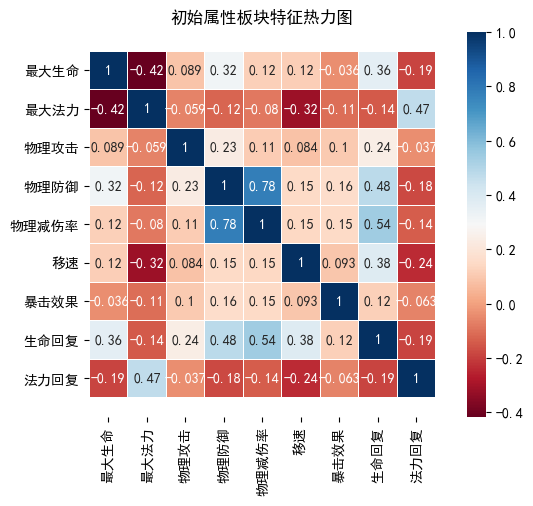

In [11]:
feature(hero0 ,'初始属性板块特征热力图',8,5)

我们可以看到在只考虑英雄的初始属性时，最大相关性为0.78。同样，我们保留所有特征(9个)。接下来，我们对其进行K-means聚类：

## 初始属性聚类分析<a name="s4"></a>

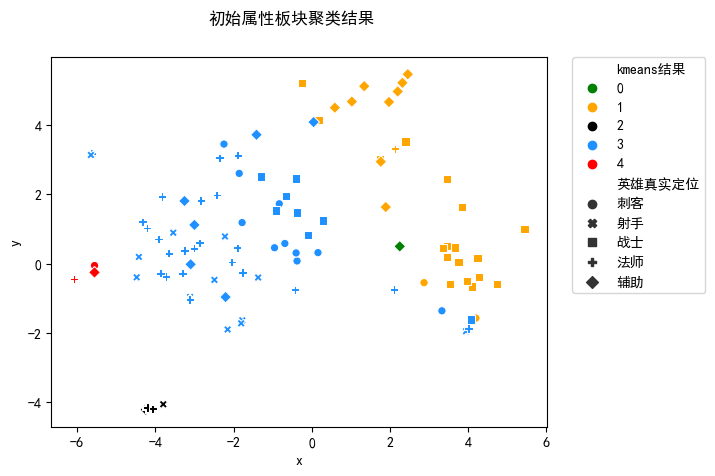

只考虑初始属性时:

真实结果的轮廓系数为：-0.027080497460571333（整体区分度）
聚类结果的轮廓系数为：0.3062010483601943
聚类结果的最大准确率为：43.56%
聚类结果最大准确率对应关系：{'刺客': 4, '射手': 2, '战士': 1, '法师': 3, '辅助': 0}


,precision,recall,f1-score,support
刺客,0.33,0.07,0.12,14.00
射手,0.17,0.07,0.10,14.00
战士,0.60,0.69,0.64,26.00
法师,0.38,0.79,0.51,29.00
辅助,1.00,0.06,0.11,18.00
accuracy,0.44,0.44,0.44,0.44
macro avg,0.50,0.34,0.30,101.00
weighted avg,0.51,0.44,0.36,101.00


In [12]:
hero0_std = standardize(hero0) # 数据归一化
kmeans1 = kmeans(hero0_std)[0]; #K-means聚类学习过程
SC_k1 = kmeans(hero0_std)[1]; SC_r1 = kmeans(hero0_std)[2]; #求轮廓系数
data_2d1 = tsne(hero0_std,kmeans1,35) #t-SNE可视化，求出低维坐标
mapp1 = accuracy(data_2d1)[0]; accur1 =accuracy(data_2d1)[1]; result1 = accuracy(data_2d1)[2];

matplotlib.rcParams['font.sans-serif']=['SimHei'] 
matplotlib.rcParams['axes.unicode_minus']=False 
ax = sns.scatterplot(x='x', y='y', hue="kmeans结果",data=data_2d1,style='英雄真实定位',
                     palette=['green','orange','black','dodgerblue','red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('初始属性板块聚类结果')
plt.show()

print('只考虑初始属性时:\n')
print('真实结果的轮廓系数为：{}（整体区分度）'.format(SC_r1))
print('聚类结果的轮廓系数为：{}'.format(SC_k1))
print('聚类结果的最大准确率为：{:.2f}%'.format(100*accur1))
print('聚类结果最大准确率对应关系：{}'.format(mapp1))
pd.options.display.float_format = '{:,.2f}'.format
display(result1)

我们可以看到，在只考虑英雄的初始属性时，整体区分度小于0，各个定位的f1-score都非常小。这说明王者荣耀对于各个英雄的初始属性设计并没有按照英雄的定位进行区分，不同定位英雄的初始属性大同小异。

# 铭文板块<a name="p3"></a>

In [13]:
minwen = pd.read_csv('minwen.csv',index_col=False)
minwen.head()

,最大生命,物理攻击,法术攻击,物理防御,物理护甲穿透,法术护甲穿透,攻速加成,暴击几率,暴击效果,物理吸血
0,0.00,20.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00
1,0.00,20.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00
2,0.00,20.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00
3,0.00,20.00,0.00,0.00,36.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,42.00,0.00,0.00,24.00,0.00,0.00,0.00,0.00


## 铭文板块特征工程<a name="s5"></a>

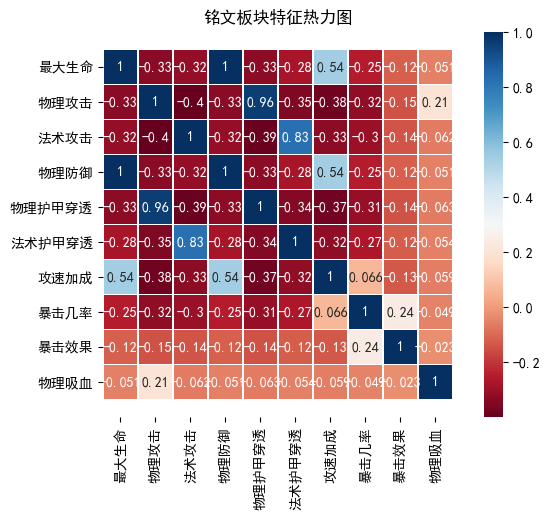

In [14]:
feature(minwen ,'铭文板块特征热力图',8,5)

物理攻击和物理护甲穿透的相关性达到了0.96，因此我们将物理护甲穿透这个特征去掉：

In [15]:
minwen.drop('物理护甲穿透',axis=1,inplace=True)

## 铭文板块聚类分析<a name="s6"></a>

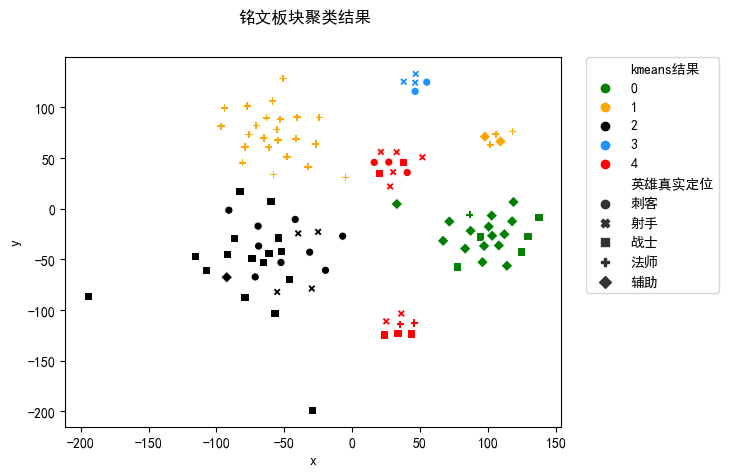

只考虑初始属性时:

真实结果的轮廓系数为：0.19394250907188343（整体区分度）
聚类结果的轮廓系数为：0.830898957366559
聚类结果的最大准确率为：65.35%
聚类结果最大准确率对应关系：{'刺客': 3, '射手': 4, '战士': 2, '法师': 1, '辅助': 0}


,precision,recall,f1-score,support
刺客,0.40,0.14,0.21,14.00
射手,0.41,0.50,0.45,14.00
战士,0.53,0.62,0.57,26.00
法师,0.93,0.90,0.91,29.00
辅助,0.71,0.83,0.77,18.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.60,0.60,0.58,101.00
weighted avg,0.64,0.65,0.64,101.00


In [16]:
minwen_std = standardize(minwen) # 数据归一化
kmeans2 = kmeans(minwen_std)[0]; #K-means聚类学习过程
SC_k2 = kmeans(minwen_std)[1]; SC_r2 = kmeans(minwen_std)[2]; #求轮廓系数
data_2d2 = tsne(minwen_std,kmeans2,2) #t-SNE可视化，求出低维坐标
mapp2 = accuracy(data_2d2)[0]; accur2 =accuracy(data_2d2)[1]; result2 = accuracy(data_2d2)[2];

matplotlib.rcParams['font.sans-serif']=['SimHei'] 
matplotlib.rcParams['axes.unicode_minus']=False 
ax = sns.scatterplot(x='x', y='y', hue="kmeans结果",data=data_2d2,style='英雄真实定位',
                     palette=['green','orange','black','dodgerblue','red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('铭文板块聚类结果')
plt.show()

print('只考虑初始属性时:\n')
print('真实结果的轮廓系数为：{}（整体区分度）'.format(SC_r2))
print('聚类结果的轮廓系数为：{}'.format(SC_k2))
print('聚类结果的最大准确率为：{:.2f}%'.format(100*accur2))
print('聚类结果最大准确率对应关系：{}'.format(mapp2))
pd.options.display.float_format = '{:,.2f}'.format
display(result2)

可以明显看到，在铭文板块K-means学习出了很好的聚类，聚类结果的轮廓系数达到了0.83.但是其中只有法师和辅助基本各自处在一个聚类上，在另外几个聚类中刺客、射手、和战士出现了很大的混合，这导致整体区分度（真实定位标定的轮廓系数）变得很小，仅为0.19，但仍然比综合属性要高。

# 装备板块<a name="p4"></a>

装备板块在之前已经利用MCA降维对其做完了特征工程，我们直接用之前的结果：

In [17]:
zhuangbei.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.56,0.65,-0.72,-0.04,-0.60,0.82,-0.18,0.41,0.03,1.32,0.06,0.41,0.06,-0.25,0.22,-0.37,0.84,0.72,0.68,-0.39
1,-0.34,-0.66,0.79,-0.34,1.00,2.30,1.48,-1.45,-0.03,-0.56,-0.78,-0.18,1.41,-0.73,-0.10,-0.78,-0.53,-1.14,0.53,0.03
2,-0.80,-0.31,-0.73,0.06,0.09,-0.06,0.11,-0.43,-0.11,-0.05,0.24,0.66,-0.54,-0.24,-0.00,-0.17,0.29,-0.03,-0.28,0.13
3,-0.57,0.02,-1.53,-0.30,0.62,1.44,-1.24,2.26,2.45,-1.08,-0.47,0.77,0.42,-0.09,0.05,0.30,-1.21,-0.38,-0.89,0.36
4,1.28,-0.27,-0.14,0.81,-0.50,-0.07,-0.64,0.11,-1.02,-0.38,-1.31,-0.30,-0.49,-0.69,0.26,0.57,-0.47,-0.41,-0.35,-0.34


## 装备板块聚类分析<a name="s7"></a>

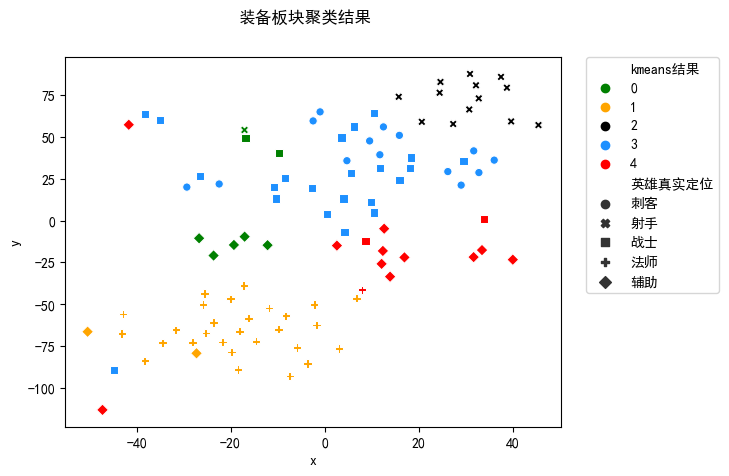

只考虑英雄装备时:

真实结果的轮廓系数为：0.11891385205430803（整体区分度）
聚类结果的轮廓系数为：0.20570533684379072
聚类结果的最大准确率为：73.27%
聚类结果最大准确率对应关系：{'刺客': 0, '射手': 2, '战士': 3, '法师': 1, '辅助': 4}


,precision,recall,f1-score,support
刺客,0.00,0.00,0.00,14.00
射手,1.00,0.93,0.96,14.00
战士,0.61,0.85,0.71,26.00
法师,0.93,0.97,0.95,29.00
辅助,0.79,0.61,0.69,18.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.67,0.67,0.66,101.00
weighted avg,0.70,0.73,0.71,101.00


In [18]:
kmeans3 = kmeans(zhuangbei)[0]; #K-means聚类学习过程
SC_k3 = kmeans(zhuangbei)[1]; SC_r3 = kmeans(zhuangbei)[2]; #求轮廓系数
data_2d3 = tsne(zhuangbei,kmeans3,16.8) #t-SNE可视化，求出低维坐标
mapp3 = accuracy(data_2d3)[0]; accur3 =accuracy(data_2d3)[1]; result3 = accuracy(data_2d3)[2];

matplotlib.rcParams['font.sans-serif']=['SimHei'] 
matplotlib.rcParams['axes.unicode_minus']=False 
ax = sns.scatterplot(x='x', y='y', hue="kmeans结果",data=data_2d3,style='英雄真实定位',
                     palette=['green','orange','black','dodgerblue','red'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('装备板块聚类结果')
plt.show()

print('只考虑英雄装备时:\n')
print('真实结果的轮廓系数为：{}（整体区分度）'.format(SC_r3))
print('聚类结果的轮廓系数为：{}'.format(SC_k3))
print('聚类结果的最大准确率为：{:.2f}%'.format(100*accur3))
print('聚类结果最大准确率对应关系：{}'.format(mapp3))
pd.options.display.float_format = '{:,.2f}'.format
display(result3)

装备板块的整体区分度为0.12，比综合属性（0.10）稍微高一点。该板块对法师和射手的区分度很高，其中法师的f1-score达到了0.95，射手的f1-score达到了0.96。

# 最后讨论<a name="p5"></a>

我们将上面的结果进行汇总：

In [19]:
zh_f1 = result0['f1-score'][:5]
cs_f1 = result1['f1-score'][:5]
mw_f1 = result2['f1-score'][:5]
zb_f1 = result3['f1-score'][:5]
sc = [SC_r0,SC_r1,SC_r2,SC_r3];
conc = pd.concat([zh_f1,cs_f1,mw_f1,zb_f1],axis=1).T
conc.insert(loc=0, column='整体区分度', value=sc); 
conc.columns = ['整体区分度','刺客区分度','射手区分度','战士区分度','法师区分度','辅助区分度']
conc.index = ['综合属性','初始属性板块','铭文板块','装备板块']
conc

,整体区分度,刺客区分度,射手区分度,战士区分度,法师区分度,辅助区分度
综合属性,0.11,0.12,0.67,0.68,0.97,0.82
初始属性板块,-0.03,0.12,0.10,0.64,0.51,0.11
铭文板块,0.19,0.21,0.45,0.57,0.91,0.77
装备板块,0.12,0.00,0.96,0.71,0.95,0.69


经过上面的分析我们可以发现：
1. **三大板块以及综合属性对英雄定位的整体区分度都不高，都不超过最大值的20%。**但这并不代表设计师没有对英雄的定位做出很好的区分。因为我们只获取了英雄的初始属性、铭文以及出装这三类信息，事实上每个英雄都有自己独特的技能，例如刺客的位移技能多，辅助的控制技能多，法师的AOE伤害技能多，战士的开团技能多。另外，在装备数据的处理中，我们仅仅将其转化成0-1数据，并没有考虑不同装备之间的具体差别。事实上，很多辅助装备都有一些增益队友的主动技能，还有很多装备会随着叠加层数而获得更强的属性。这些因素都无法用数字来量化，因此我们只能将视野限制在初始属性、铭文和装备这三个板块上。
2. **在初始属性板块中，所有定位的区分度都很低。**说明各英雄的初始属性都很接近。
3. **在铭文板块中，法师和辅助的区分度很高。**事实上，王者荣耀里只有两种伤害形式：物理伤害和法术伤害。而法师都会佩戴大量增加法术伤害的铭文，因此铭文板块对法师区分度高。对于辅助，一般会佩戴能增加坦度的铭文，同样有很高的区分度。剩下的刺客、战士和射手都是物理伤害，都会佩戴增加物理伤害的铭文，因此区分度很低。
4. **在装备板块中，法师和射手的区分度很高。**因为法师一定会出法术装备，而射手一定会出增加攻速的装备。对于辅助和刺客来说，虽然他们都有其独特的装备（辅助装和打野刀），但由于只占了一格装备，比重较低，对距离的影响太小，导致K-means学习出来的结果的f1-score不高。
5. **综合属性对法师和辅助的区分度很高。**